$\newcommand{\P}{\mathbb{P}}$
$\newcommand{\E}{\mathbb{E}}$
`l[i, j]` := $\P(x_i | \theta, Y_i = j) $

`pi[j] ` := $\pi_j = \P(Y_i = j | \theta)$

`P[i, j]` = $ \P(Y_i = j | \theta, x_i) \propto \P(x_i, Y_i = j | \theta) \cdot \P(Y_i = j | \theta)$


$G(P, \theta)  := \E_P\Big[\log \P(y, z, \theta)\Big]$

In [1]:
import tensorflow as tf
import tensorflow.distributions as tfd

In [2]:
tf.enable_eager_execution()

In [3]:
import numpy as np
import numpy.random as rnd

In [4]:
import matplotlib.pyplot as pl
%matplotlib inline

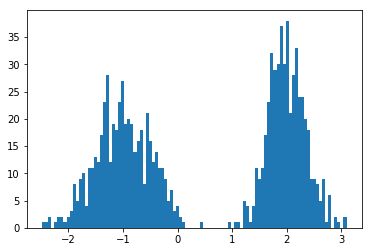

In [17]:
def generate_sample(pi, mu, sigma, N):
    K = len(pi)
    x = rnd.normal(loc = [mu], scale = [sigma], size = [N, K])
    y = rnd.choice(K, size = N)
    x = x[range(N),y]
    return x

    
z = generate_sample(
    pi = [1/3, 2/3],
    mu = [-1, 2],
    sigma = [1/2, 1/3],
    N = 1000,
)
N = len(z)
    
pl.hist(z, 100);

denote $\beta:= \log(\sigma^2)$ i.e. $\sigma = e^{\beta/2}$

In [6]:
K = 2
π_prior = tfd.Dirichlet(2 * np.ones(K))
μ_prior = tfd.Normal(loc = np.zeros(K), scale = np.ones(K))
β_prior = tfd.Normal(loc = np.zeros(K), scale = np.ones(K))

In [7]:
θ_priors = (π_prior, μ_prior, β_prior)
θ_priors

(<tf.distributions.Dirichlet 'Dirichlet/' batch_shape=() event_shape=(2,) dtype=float64>,
 <tf.distributions.Normal 'Normal/' batch_shape=(2,) event_shape=() dtype=float64>,
 <tf.distributions.Normal 'Normal/' batch_shape=(2,) event_shape=() dtype=float64>)

In [12]:
θ = π, μ, β = [ tf.Variable(prior.sample(), name = name)
    for name, prior in zip(["pi","mu", "beta"], [π_prior, μ_prior, β_prior])]

In [22]:
def θ_log_prior(θ) -> "scalar":
    """$\log P(θ)$"""
    return tf.add_n([
        tf.reduce_sum(prior.log_prob(x)) 
        for x, prior in zip(θ, θ_priors)
    ])

In [9]:
def log_lhd(z, y, θ) -> "scalar":
    """$\log P(z|y, θ)$"""
    
    # vectors of length `K`
    π, μ, β = θ 
    σ = tf.exp(β / 2)
    
    # vectors of lenght `N`
    loc = tf.gather(μ, indices = y)
    scale = tf.gather(σ, indices=y) 
    return tfd.Normal(loc, scale).log_prob(z)

In [10]:
def log_lhds_as_fun_of_y(z, θ) -> "Tensor of shape (N, K)":
    """return `a[i, y] = \log P(z_i| Y_i = y, θ)$"""
    
    # vectors of length `K`
    π, μ, β = θ 
    σ = tf.exp(β / 2)
     
    return tfd.Normal(loc = μ[None, :], scale = σ[None, :]).log_prob(z[:, None])

In [14]:
log_lhds_as_fun_of_y(z, θ).shape

TensorShape([Dimension(1000), Dimension(2)])

* **E-step:** for fixed $\theta$ and each $i$ calculate "posterior density of $Y_i$ given $z_i$, $\theta$":
$$ P_i(y) := \P(Y_i = y\mid \theta, z_i) \propto \P(Y_i = y\mid \theta) \cdot \P(z_i\mid \theta, Y_i = y)$$
i.e. `P[i, y] := pi[y] * Norm(loc=mu[y], scale = sigma[y]).log_prob(z[i])` and then normalize wrt `y`-index.

In [19]:
def E_step(z:(N,), θ:(K,)) -> (N, K) :
    """Return 'posterior' distribution `P(y)` on `Y` given `z`, `θ`."""
    π, μ, β = θ
    σ = tf.exp(β / 2)
    P = π * tfd.Normal(μ[None, :], σ[None, :]).log_prob(z[:, None])
    P = P / tf.reduce_sum(P, axis=-1, keepdims=True)
    return P

P = E_step(z, θ)

$\newcommand{\argmax}[1]{\underset{#1}{\mathrm{argmax}}}$
* **M-step:** Now fix all $P_i$ and maximize
$$\log\P(\theta) + \sum_i\sum_y P_i(y)\cdot\log\P(z_i, Y_i = y| \theta) = \log\P(\theta) + \sum_i\sum_y P_i(y)\big[ \log\P(z_i| Y_i = y, \theta) + \pi_y \big]$$

In [20]:
optimizer = tf.train.AdamOptimizer()

In [93]:
def M_step(P, θ, z, n_steps = 10):
    """Apply several steps of gradient descent wrt `θ` and return the result. """
    
    with tf.GradientTape() as tape:
        loss = - θ_log_prior(θ) - tf.reduce_sum(P * (log_lhds_as_fun_of_y(z, θ) + π))

    grad = tape.gradient(loss, θ)
    optimizer.apply_gradients(zip(grad, θ))
    
    #print("Current loss:", loss)
    return θ


θ = M_step(P, θ, z)
θ

[<tf.Variable 'pi:0' shape=(2,) dtype=float64, numpy=array([1.52744708, 1.59930266])>,
 <tf.Variable 'mu:0' shape=(2,) dtype=float64, numpy=array([-0.37782104,  0.85405181])>,
 <tf.Variable 'beta:0' shape=(2,) dtype=float64, numpy=array([1.40244721, 1.06223049])>]

In [ ]:
def plot_distr(θ, interval):
    π, μ, β = θ
    σ = tf.exp(β / 2)
    
    xxx = np.linspace(*interval, 200)
    yyy = tf.reduce_sum(
        π * tfd.Normal(loc = μ[None, :], scale = σ[None, :]).prob(xxx[:, None]),
        axis = -1
    )
    pl.plot(xxx, yyy)
 

[<tf.Variable 'pi:0' shape=(2,) dtype=float64, numpy=array([2.51913294, 2.60646177])>, <tf.Variable 'mu:0' shape=(2,) dtype=float64, numpy=array([0.28684811, 0.51581705])>, <tf.Variable 'beta:0' shape=(2,) dtype=float64, numpy=array([0.95080178, 0.91200986])>]


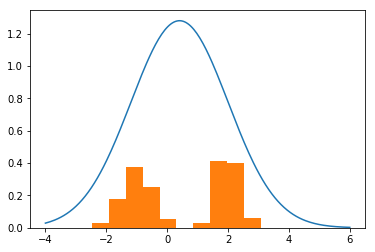

In [94]:
for i in range(1000):
    P = E_step(z, θ)
    θ = M_step(P, θ, z, n_steps=10000)
   
plot_distr(θ, [-4, 6])
pl.hist(z, density = True);
print(θ)